In [12]:
import torch
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
import pyvista as pv
pv.start_xvfb()
import pickle


import plotly.graph_objects as go
import plotly.express as px


%load_ext autoreload
%autoreload 2
from help_functions.make_conv_2d_torch import make_conv_2d_torch
from help_functions.make_conv_3d_torch import make_conv_3d_torch
from help_functions.morph_fill import morph_fill, morph_fill_fast
from help_functions.Sub_AT_torch import Sub_AT_torch
from help_functions.Sub_A_torch import Sub_A_torch
from help_functions.solve_least_squares_subdivision import solve_least_squares_subdivision
from help_functions.plot_subdivision_points import plot_subdivision_points
# from help_functions.solve_least_squares_subdivision import apply_C
from help_functions.shadows_visual import shadows_visual, shadows_visual_UI, shadows_visual_volume_plotly
from help_functions.fast_optimization import (Sub_A_fast, 
                                              Sub_AT_fast, 
                                              solve_least_squares_subdivision_fast,
                                              solve_least_squares_subdivision_CG,
                                              build_kernel)

from help_functions.make_html_visual import make_html_visual
from help_functions.make_scatter_visual import make_scatter_visual

from IPython.display import HTML
import kaleido
import plotly.io as pio



/tmp/ipykernel_5978/3557779266.py:12: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk with osmesa instead.
  pv.start_xvfb()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def Sub_A(p, x_0):
    # Схема подразделений через преобразование Фурье.
    # Здесь предполагается, что последовательность x_0
    # периодическая и задана на периоде [0; n_1 - 1] x ...
    # p -- маска -- массив numpy размера q < min n_i
    s = len(x_0.shape)
    if (s == 1):
        a = p.clone()
    elif (s == 2):
        a = np.tensordot(p, p, axes = 0)
    else:
        a = np.tensordot(p, np.tensordot(p, p, axes = 0), axes = 0)
    x = x_0.clone() 
    
    Up_x = np.zeros(tuple(2 * np.array(x.shape)))
    DFT_a = np.zeros(Up_x.shape)
    if (s == 1):
        Up_x[::2] = x[:]
        DFT_a[:a.shape[0]] = a[:]
        DFT_a = np.fft.fftn(DFT_a)
    elif (s == 2):
        Up_x[::2, ::2] = x[:, :]
        DFT_a[:a.shape[0], :a.shape[1]] = a[:, :]
        DFT_a = np.fft.fftn(DFT_a)
    else:
        Up_x[::2, ::2, ::2] = x[:, :, :]
        DFT_a[:a.shape[0], :a.shape[1], :a.shape[2]] = a[:, :, :]
        DFT_a = np.fft.fftn(DFT_a)
    x = np.fft.ifftn(DFT_a * np.fft.fftn(Up_x)).real
    return x

In [ ]:
# from help_functions.Sub_A_torch import Sub_A_torch
# from help_functions.fast_optimization import Sub_A_fast, Sub_AT_fast

# # plt.figure(figsize=(6, 5))
    
# # plt.imshow(budda_conv_result_2D_filled, 
# #            cmap='viridis', 
# #            aspect='auto',
# #            origin='lower')  

# # plt.colorbar(label='Значение')
# # plt.xlabel('X координата')
# # plt.ylabel('Y координата')

# # plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# # plt.tight_layout()
# # plt.savefig('./images/budda-2d-slice-after-conv.png')
# # plt.show()
# data = budda_conv_result_3D[:,:, 500].to(torch.float32)
# mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4
# mask_fast = build_kernel(torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4, dim=2)


# x0_subdivisioned = Sub_A_torch(mask, data)
# x0_subdivisioned_fast = Sub_A_fast(data, mask_fast)
# x0_fourie = Sub_A(mask, data)



In [ ]:
# x0_subdivisioned_fast.shape

torch.Size([607, 607])

In [ ]:
# torch.allclose(x0_subdivisioned, x0_subdivisioned_fast)

True

In [45]:
'''
Здесь импортируем изображение, центрируем и поворачиваем при надобности
'''

raw_data = np.loadtxt('./models/BuddaAll.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*5000).astype(int).reshape(-1, 3)


shifted = (int_cast_data - int_cast_data.min(axis=0) + np.array([10,10,10]))
sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + np.array([20,20, 20])).astype(int)
budda_tensor_3D = torch.zeros(tuple(sizes), dtype=torch.float16)

budda_tensor_3D[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

budda_tensor_3D_rotated_90 = torch.rot90(input = budda_tensor_3D, k=1, dims=(1, 2))

print (f"Количество точек {len(torch.argwhere(budda_tensor_3D != 0))}")

# make_scatter_visual(budda_tensor_3D_rotated_90, 'budda_input_data')
# make_html_visual(tensor_3d=budda_tensor_3D, name='budda-raw', colorscale='Jet')

budda_tensor_3D = budda_tensor_3D_rotated_90


Количество точек 420936


In [16]:
budda_tensor_3D.dtype

torch.float16

In [46]:
def spherical_kernel_3d(radius: int, dim = 3) -> torch.Tensor:
    size = 2 * radius + 1
    center = radius
    
    if dim == 3:
        z, y, x = torch.meshgrid(
        torch.arange(size),
        torch.arange(size),
        torch.arange(size),
        indexing='ij'
    )
        dist_sq = (x - center)**2 + (y - center)**2 + (z - center)**2
        kernel = (dist_sq <= radius**2).float()
    elif dim == 2:
        y, x = torch.meshgrid(
        torch.arange(size),
        torch.arange(size),
        indexing='ij'
    )
        dist_sq = (x - center)**2 + (y - center)**2
        kernel = (dist_sq <= radius**2).float()
        
    return kernel


In [54]:
'''
Здесь утолщаем границы
'''

# budda_tensor_3D_slice = budda_tensor_3D[:,:, 30]

# kernel_2D = torch.ones(size=(3,3))
radius = 5   # примерно kernel_shape // 2
kernel_3D = spherical_kernel_3d(radius)

# kernel_shape = 9
# kernel_3D = torch.ones(size=(kernel_shape,kernel_shape,kernel_shape))
# kernel_2D = torch.ones(size=(kernel_shape,kernel_shape))

# budda_conv_result_2D = make_conv_2d_torch(source=budda_tensor_3D_slice, kernel=kernel_2D)
budda_conv_result_3D = make_conv_3d_torch(source=budda_tensor_3D, kernel=kernel_3D)

# budda_conv_result_3D = budda_tensor_3D.clone()
# for layer in range(budda_conv_result_3D.shape[2]):
#     budda_conv_result_3D[:,:,layer] = make_conv_2d_torch(budda_conv_result_3D[:,:,layer], kernel=kernel_2D)




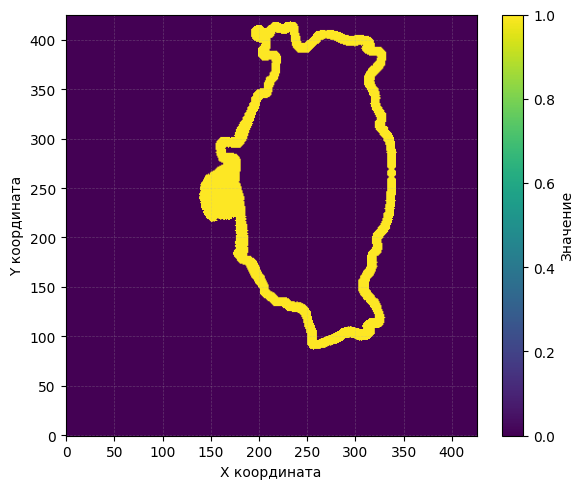

In [55]:
plt.figure(figsize=(6, 5))
    
plt.imshow(budda_conv_result_3D[:,:, 700], 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/budda-2d-slice-after-conv.png')
plt.show()


In [5]:
make_html_visual(budda_conv_result_3D, 'budda_conv_result_3D_3')
# HTML(filename='./htmls/voxel_model_budda_5_rare.html')

Файл сохранен в ./htmls/budda_conv_result_3D_3.html


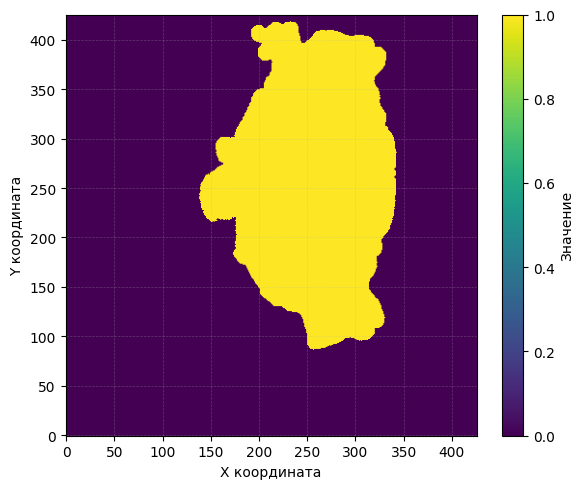

In [56]:
'''
Морфологическое заполнение
'''


# budda_conv_result_2D_filled = morph_fill(budda_conv_result_3D[:,:, 100])

budda_conv_result_2D_filled = morph_fill_fast(budda_conv_result_3D[:,:, 700])

plt.figure(figsize=(6, 5))
    
plt.imshow(budda_conv_result_2D_filled, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()

In [57]:
# budda_conv_result_3D_filled = morph_fill_fast(budda_conv_result_3D)

budda_conv_result_3D_filled = budda_conv_result_3D.clone()
for layer in range (budda_conv_result_3D.shape[2]):
    budda_conv_result_3D_filled[:,:,layer] = morph_fill_fast(budda_conv_result_3D_filled[:,:,layer])



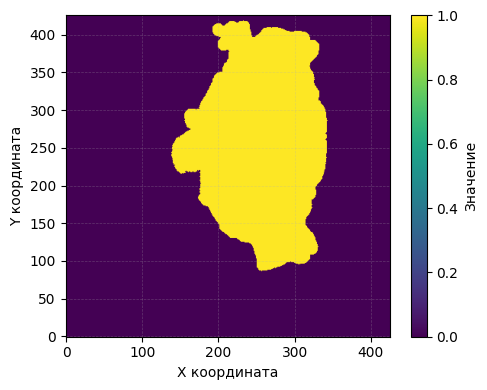

In [58]:
plt.figure(figsize=(5, 4))
    
plt.imshow(budda_conv_result_3D_filled[:, :, 700], 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()

In [ ]:
# mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4
mask = torch.tensor([1 / 4, 3 / 4, 3 / 4, 1 / 4, 0], dtype=torch.float32)


# Z - характористическая функция поверхности
Z = budda_conv_result_3D_filled


x0 = solve_least_squares_subdivision_CG(Z, mask, j = 3, tol = 1e-1, max_iter=20)
# z_rec = Sub_A_torch(mask, x0)

# error = torch.norm(z_rec - Z)
# print(error)

CG ITER 0: residual = 1.246383e+04
CG ITER 1: residual = 5.859908e+03
CG ITER 2: residual = 3.492141e+03
CG ITER 3: residual = 2.222295e+03
CG ITER 4: residual = 1.540697e+03
CG ITER 5: residual = 1.167806e+03
CG ITER 6: residual = 9.325803e+02
CG ITER 7: residual = 7.381045e+02
CG ITER 8: residual = 5.843038e+02
CG ITER 9: residual = 4.724088e+02
CG ITER 10: residual = 3.937935e+02
CG ITER 11: residual = 3.266778e+02
CG ITER 12: residual = 2.742894e+02
CG ITER 13: residual = 2.310995e+02
CG ITER 14: residual = 1.984545e+02
CG ITER 15: residual = 1.753765e+02
CG ITER 16: residual = 1.517359e+02
CG ITER 17: residual = 1.336357e+02
CG ITER 18: residual = 1.191399e+02
CG ITER 19: residual = 1.060540e+02


In [10]:
torch.save(x0, './tensor_files/x0_3500_7_j3.pt') 

In [3]:
Z = torch.load('./Z.pt')

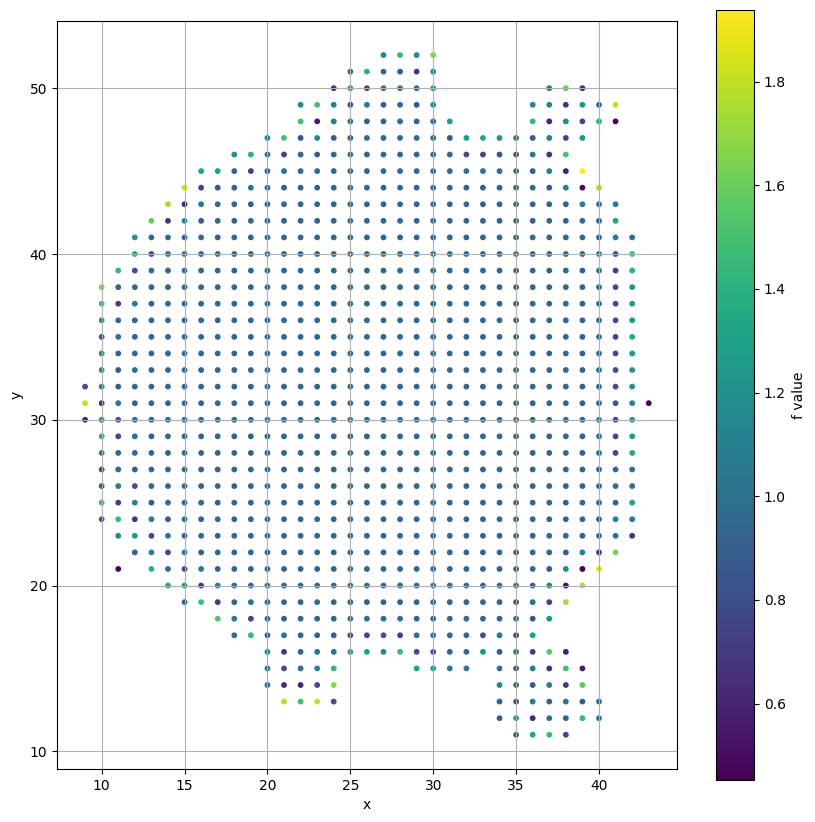

In [65]:
plot_subdivision_points(x0[:,:,70], threshold=0.4, do_ceil=False)

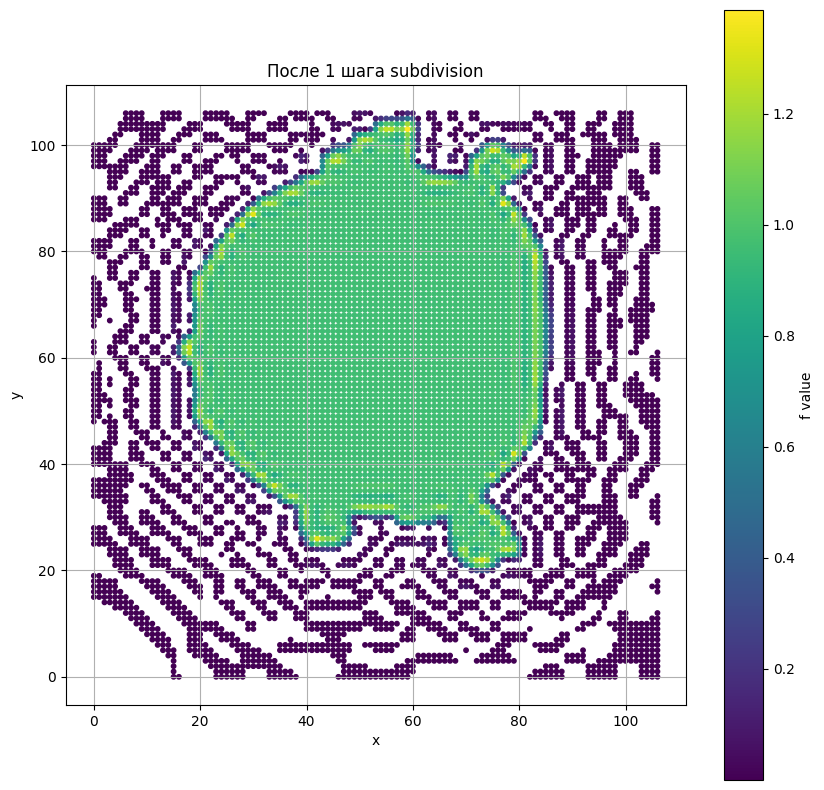

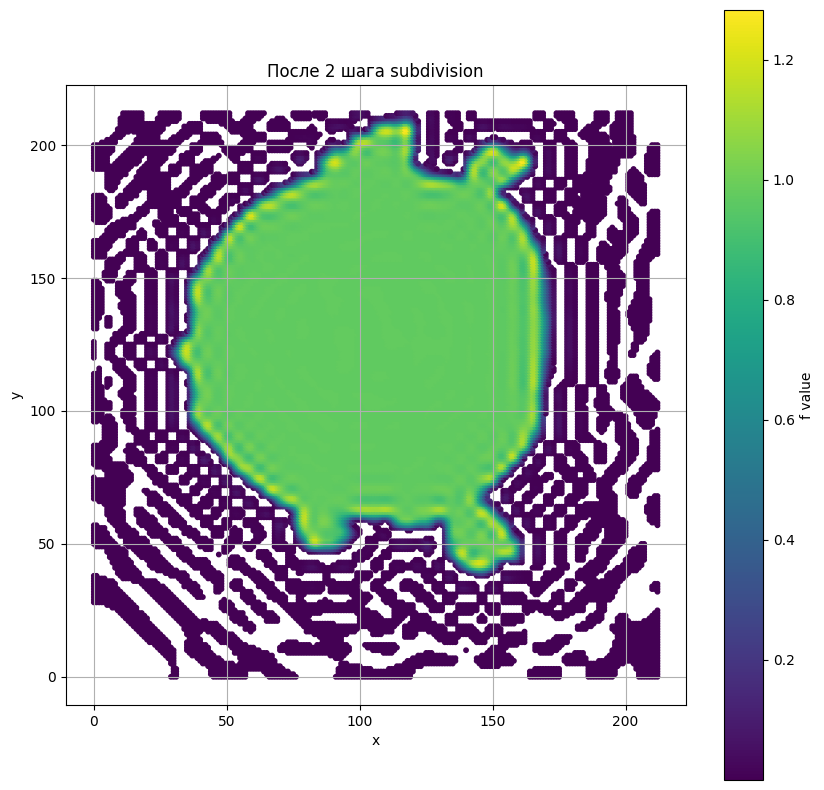

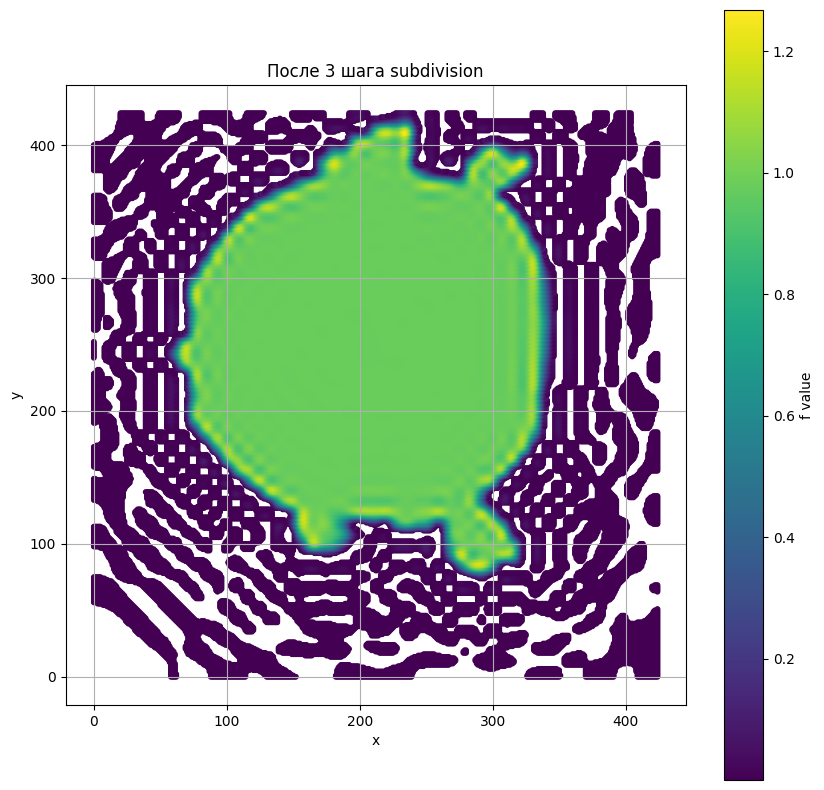

In [66]:
# mask = torch.tensor([1 / 4, 3 / 4, 3 / 4, 1 / 4, 0], dtype=torch.float32)
mask = build_kernel(torch.tensor([1 / 4, 3 / 4, 3 / 4, 1 / 4, 0], dtype=torch.float32), dim = 3)


x0_subdivisioned = x0.clone()
k = 2
for i in range(3):
    x0_subdivisioned = Sub_A_fast(x0_subdivisioned, mask)
    plot_subdivision_points(
        x0_subdivisioned[:,:,70*k],
        threshold=0.00,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10),
        do_ceil= False,
        visual_type= 'scatter'
    )
    k *=2
    # print(k)

In [30]:
# x0_clone = Sub_A_torch(mask, x0_clone)

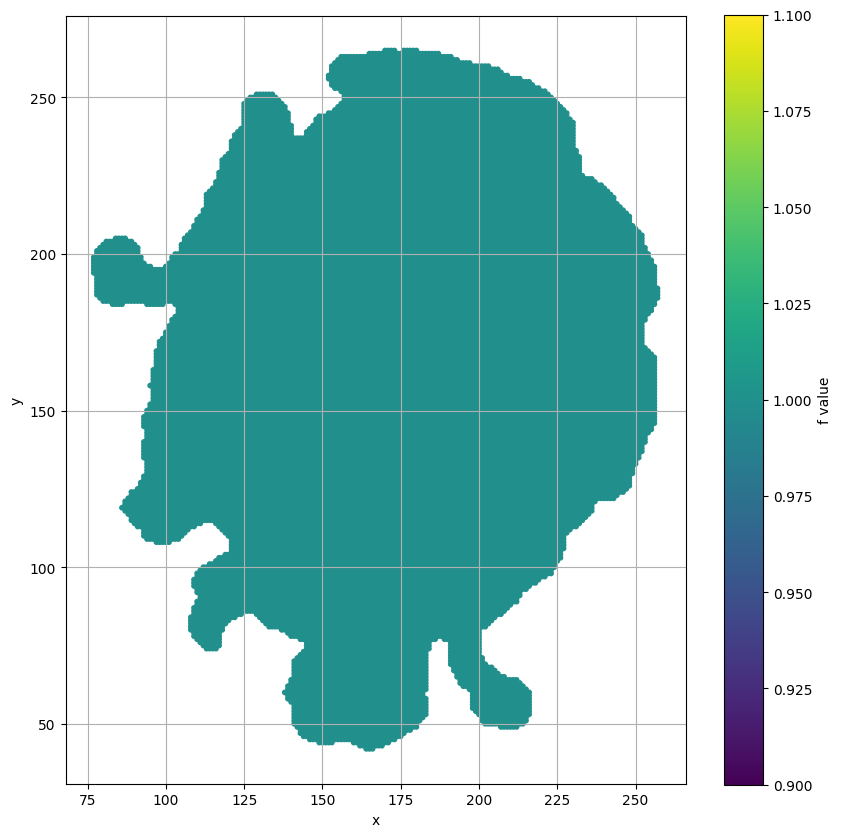

In [92]:
threshold = 0.6
# x0_clone_filtered = torch.where(x0_clone > threshold, x0_clone, torch.tensor(0.0))

x0_clone_filtered_ceil = (x0_subdivisioned > threshold).float()
plot_subdivision_points(data = x0_clone_filtered_ceil[:,:,70*4],
                        threshold=0.0,
                        title='',
                        figsize=(10,10),
                        do_ceil=False,
                        visual_type='scatter')

In [79]:
torch.save(x0_clone_filtered_ceil, './tensor_files/x0_clone_filtered_ceil.pt') 
# torch.save(Z, './tensor_files/Z.pt') 


In [24]:
import pickle
with open('./tensor_files/tensor.pkl', 'wb') as f:
    pickle.dump(Z, f)

In [93]:
shadows_visual(x0_clone_filtered_ceil, name = '18budda_subdivisioned_3500_j2_sub2_vertical', layers = 'vertical')
# shadows_visual(Z, name = '18budda_voxel_3500_vertical', layers = 'vertical')



In [34]:
x0_subdivisioned.shape

torch.Size([289, 289, 705])

In [67]:
shadows_visual(input_tensor=x0_subdivisioned, 
               name="x0_subdivisioned_5000_3", 
               layers='vertical',
               )

In [68]:
shadows_visual(input_tensor=Z, 
               name="Z_5000", 
               layers='vertical',
               )

In [7]:
with open('UIV_x.pkl', 'rb') as f:
    uiv_x = pickle.load(f)
    
uiv_x = torch.from_numpy(uiv_x)

shadows_visual(uiv_x, name = 'UIV', layers = 'vertical')


In [11]:
uiv_x.min()

tensor(-0.5145)

In [67]:
Z.shape

torch.Size([304, 304, 713])

In [29]:
shadows_visual_volume_plotly(x0_clone_filtered_ceil, name = 'orange_budda_subdivisioned_5000_j3_sub3_vertical', layers = 'vertical')


In [43]:
shadows_visual_volume_plotly(Z, name = 'orange_budda_voxel_5000_vertical', layers = 'vertical')